In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import multitask_dep as mt
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab,word_to_index) 

In [7]:
convai_train_dataset =rrnn.DatasetMultiTaskRRNN(convai_train_token,tasks,eval=False,deps=True)

In [8]:
convai_val_dataset = rrnn.DatasetMultiTaskRRNN(convai_val_token,tasks,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab,word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskRRNN(md_tokenized,tasks,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep_multi)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep_multi)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep_multi)

# Pruebas hiperparámetros 1

In [12]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

In [13]:
num_epochs = 100
learning_rate = 5e-5

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0756824307325408 	 Validation loss: 2.0809393696865794 	 
  1%|          | 574/57400 [00:07<12:06, 78.18it/s]
Epoch 2 	 Training loss: 2.074160749488591 	 Validation loss: 2.077131562313791 	 
  2%|▏         | 1148/57400 [00:15<11:34, 81.01it/s]
Epoch 3 	 Training loss: 2.0714187460078595 	 Validation loss: 2.072496208093934 	 
  3%|▎         | 1722/57400 [00:23<11:51, 78.30it/s]
Epoch 4 	 Training loss: 2.0673402174009263 	 Validation loss: 2.0767364219083624 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:31<12:19, 74.55it/s]
Epoch 5 	 Training loss: 2.06505163621404 	 Validation loss: 2.067093364262985 	 
  5%|▌         | 2870/57400 [00:39<11:29, 79.13it/s]
Epoch 6 	 Training loss: 2.0612713023760594 	 Validation loss: 2.0640482619657354 	 
  6%|▌         | 3444/57400 [00:47<11:08, 80.67it/s]
Epoch 7 	 Training loss: 2.060956937510793 	 Validation loss: 2.0610831713272355 	 
  7%|▋         | 4018/57400 [00:54<11:17, 78.79it/s]
Epoch 8 	 Tra

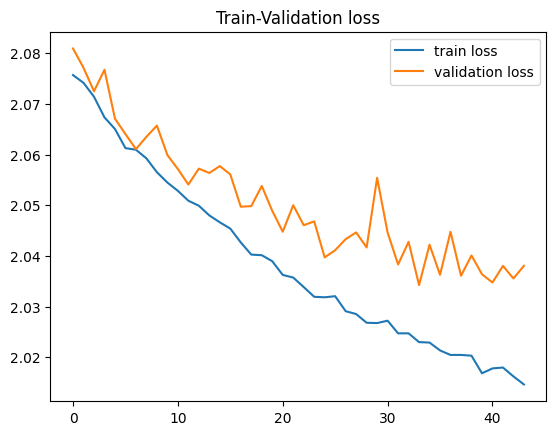

In [14]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_multi_{encoding_type}_v1_1'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5820707070707071, 'precision': 0.5820707070707071, 'f1': 0.5820707070707071, 'accuracy': 0.5820707070707071}, 'as': {'recall': 0.5671447196870926, 'precision': 0.5671447196870926, 'f1': 0.5671447196870926, 'accuracy': 0.5671447196870926}, 'about': {'recall': 0.6415816326530612, 'precision': 0.6415816326530612, 'f1': 0.6415816326530612, 'accuracy': 0.6415816326530612}} 

Evaluación en etiquetas male
{'to': {'recall': 0.49878345498783455, 'precision': 0.49878345498783455, 'f1': 0.49878345498783455, 'accuracy': 0.49878345498783455}, 'as': {'recall': 0.4318181818181818, 'precision': 0.4318181818181818, 'f1': 0.4318181818181818, 'accuracy': 0.4318181818181818}, 'about': {'recall': 0.6197916666666666, 'precision': 0.6197916666666666, 'f1': 0.6197916666666666, 'accuracy': 0.6197916666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6719160104986877, 'precision': 0.6719160104986877, 'f1': 0.6719160104986877, 'accuracy': 0.6719160104986877}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.075688813621574 	 Validation loss: 2.0809926380545405 	 
  1%|          | 574/57400 [00:07<11:42, 80.89it/s]
Epoch 2 	 Training loss: 2.071779098660273 	 Validation loss: 2.0738725621821517 	 
  2%|▏         | 1148/57400 [00:15<11:28, 81.65it/s]
Epoch 3 	 Training loss: 2.066482507808699 	 Validation loss: 2.0707123602850963 	 
  3%|▎         | 1722/57400 [00:22<11:30, 80.64it/s]
Epoch 4 	 Training loss: 2.0642955581485603 	 Validation loss: 2.0682120525230796 	 
  4%|▍         | 2296/57400 [00:30<11:29, 79.86it/s]
Epoch 5 	 Training loss: 2.060952338607469 	 Validation loss: 2.0684778286238847 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:38<11:07, 81.71it/s]
Epoch 6 	 Training loss: 2.06090605175869 	 Validation loss: 2.0678932383909063 	 
  6%|▌         | 3444/57400 [00:45<11:09, 80.59it/s]
Epoch 7 	 Training loss: 2.059956277704405 	 Validation loss: 2.0716525093983797 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:53<10

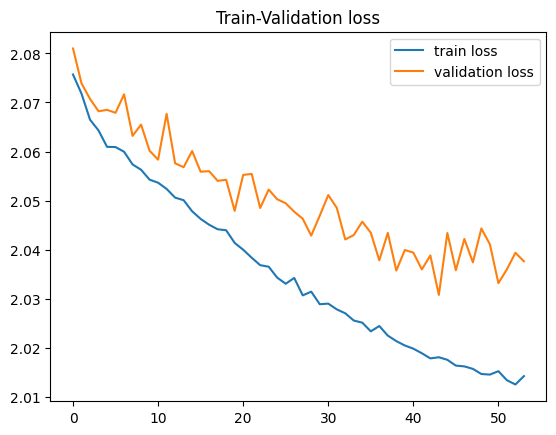

In [16]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

save_path=f'm1_rrnn_multi_{encoding_type}_v1_2'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5505050505050505, 'precision': 0.5505050505050505, 'f1': 0.5505050505050505, 'accuracy': 0.5505050505050505}, 'as': {'recall': 0.5775749674054759, 'precision': 0.5775749674054759, 'f1': 0.5775749674054759, 'accuracy': 0.5775749674054759}, 'about': {'recall': 0.6683673469387755, 'precision': 0.6683673469387755, 'f1': 0.6683673469387755, 'accuracy': 0.6683673469387755}} 

Evaluación en etiquetas male
{'to': {'recall': 0.5425790754257908, 'precision': 0.5425790754257908, 'f1': 0.5425790754257908, 'accuracy': 0.5425790754257908}, 'as': {'recall': 0.547979797979798, 'precision': 0.547979797979798, 'f1': 0.547979797979798, 'accuracy': 0.547979797979798}, 'about': {'recall': 0.6822916666666666, 'precision': 0.6822916666666666, 'f1': 0.6822916666666666, 'accuracy': 0.6822916666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.5590551181102362, 'precision': 0.5590551181102362, 'f1': 0.5590551181102362, 'accuracy': 0.5590551181102362}, 'as': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.076258505678343 	 Validation loss: 2.080234858949306 	 
  1%|          | 574/57400 [00:07<11:55, 79.40it/s]
Epoch 2 	 Training loss: 2.071679465031375 	 Validation loss: 2.0784476045834817 	 
  2%|▏         | 1148/57400 [00:15<11:37, 80.70it/s]
Epoch 3 	 Training loss: 2.0644450669504626 	 Validation loss: 2.073997946108802 	 
  3%|▎         | 1722/57400 [00:23<11:41, 79.34it/s]
Epoch 4 	 Training loss: 2.0615674896938043 	 Validation loss: 2.071088904041355 	 
  4%|▍         | 2296/57400 [00:30<11:45, 78.11it/s]
Epoch 5 	 Training loss: 2.0599174528587154 	 Validation loss: 2.0673989118155784 	 
  5%|▌         | 2870/57400 [00:38<11:22, 79.86it/s]
Epoch 6 	 Training loss: 2.0571612726105215 	 Validation loss: 2.0642494387545827 	 
  6%|▌         | 3444/57400 [00:46<25:36, 35.12it/s]
Epoch 7 	 Training loss: 2.055890492445916 	 Validation loss: 2.071485782073716 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:54<11:02, 80.53it/s]
Epoch 8 	 Tra

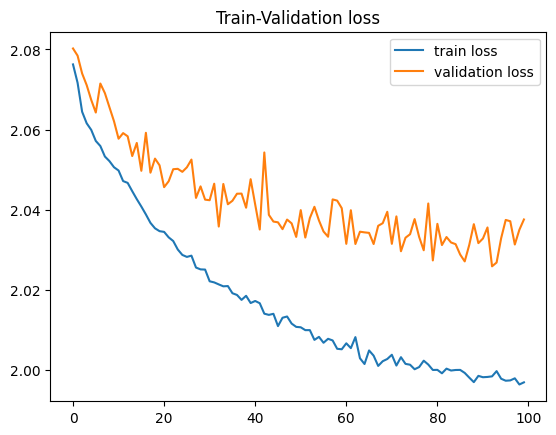

In [18]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

save_path=f'm1_rrnn_multi_{encoding_type}_v1_3'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5517676767676768, 'precision': 0.5517676767676768, 'f1': 0.5517676767676768, 'accuracy': 0.5517676767676768}, 'as': {'recall': 0.5619295958279009, 'precision': 0.5619295958279009, 'f1': 0.5619295958279009, 'accuracy': 0.5619295958279009}, 'about': {'recall': 0.6237244897959183, 'precision': 0.6237244897959183, 'f1': 0.6237244897959183, 'accuracy': 0.6237244897959183}} 

Evaluación en etiquetas male
{'to': {'recall': 0.805352798053528, 'precision': 0.805352798053528, 'f1': 0.805352798053528, 'accuracy': 0.805352798053528}, 'as': {'recall': 0.8106060606060606, 'precision': 0.8106060606060606, 'f1': 0.8106060606060606, 'accuracy': 0.8106060606060606}, 'about': {'recall': 0.8802083333333334, 'precision': 0.8802083333333334, 'f1': 0.8802083333333334, 'accuracy': 0.8802083333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.2782152230971129, 'precision': 0.2782152230971129, 'f1': 0.2782152230971129, 'accuracy': 0.2782152230971129}, 'as': 

In [20]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6445578231292517, 'precision': 0.6445578231292517, 'f1': 0.6445578231292517, 'accuracy': 0.6445578231292517}
Métricas etiqueta male: {'recall': 0.7274305555555556, 'precision': 0.7274305555555556, 'f1': 0.7274305555555556, 'accuracy': 0.7274305555555556}
Métricas etiqueta female:  {'recall': 0.565, 'precision': 0.565, 'f1': 0.565, 'accuracy': 0.565}

 to
Resultado global: {'recall': 0.5614478114478114, 'precision': 0.5614478114478114, 'f1': 0.5614478114478114, 'accuracy': 0.5614478114478114}
Métricas etiqueta male: {'recall': 0.6155717761557178, 'precision': 0.6155717761557178, 'f1': 0.6155717761557178, 'accuracy': 0.6155717761557178}
Métricas etiqueta female:  {'recall': 0.5030621172353456, 'precision': 0.5030621172353456, 'f1': 0.5030621172353456, 'accuracy': 0.5030621172353456}

 as
Resultado global: {'recall': 0.5688830943068232, 'precision': 0.5688830943068232, 'f1': 0.5688830943068232, 'accuracy': 0.5688830943068232}
Mét